In [2]:
from sympy import *
import copy
import matplotlib.pyplot as plt
import numpy as np

# **CODIGO DEL MODELO**

In [3]:
plt.style.use("dark_background")

for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  # very light grey

for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'  # bluish dark grey

In [28]:
p, q = symbols("p q")

# Aquí, pides al usuario el número de demandas e inicializas símbolos para esas demandas.
numero_de_demandas = int(input("Cuantas demandas serán? => "))
demandas_claves = [symbols(f'q_{i}') for i in range(1, numero_de_demandas+1)]
N_claves = [f"n{i}" for i in range(1, numero_de_demandas + 1)]

# Aquí se recopilan las demandas y cantidades. El uso de diccionarios es adecuado para este propósito.
N = {N_clave:float(input(f"{N_clave} = ")) for N_clave in N_claves}
demandas = {q:sympify(input(f'{q} = ')) for q in demandas_claves}
costo = sympify(input(f'COSTO = '))

# Haces una copia profunda de las demandas para comparar más adelante
demandas_sin_modificar = copy.deepcopy(demandas)

Cuantas demandas serán? => 2
n1 = 1
n2 = 1
q_1 = 60-p
q_2 = 70-p
COSTO = 50+10*q


In [29]:
# 2. Funciones constantes a graficar
CMg = diff(costo, q)

In [30]:
# 3. Esta función calcula ecuaciones para el precio en función de la cantidad.
p_q = {}
def ecuaciones_precio_respecto_cantidad():
  p_q[p]=[]
  for cantidad, ecuacion in demandas.items():
    expresion_cantidad, expresion_ecuacion = sympify(cantidad), sympify(ecuacion)
    ecuation = Eq(expresion_cantidad, expresion_ecuacion)
    solution = solve(ecuation, p)
    p_q[p].append(solution)
  return(p_q)

ecuaciones_pq = ecuaciones_precio_respecto_cantidad()

# Hago el arreglo de los valores de p respecto a q para que se pueda iterar de manera normal.
ecuaciones_pq_values = [values for lista_externa in ecuaciones_pq.values() for lista_interna in lista_externa for values in lista_interna]

[60 - q_1, 70 - q_2]

In [31]:
# Esta función decide qué demanda será la escogida para hallar el área de A.
def demanda_a_eliminar_por_derivada():
    # Obteniendo las constantes (despejando p)
    constantes = [ecuacion.subs(q_x,0) for ecuacion, q_x in zip(ecuaciones_pq_values, demandas.keys())]

    # Identificando la constante repetida
    constante_repetida = next((x for x in set(constantes) if constantes.count(x) > 1), None)

    if not constante_repetida:
        return None

    # Identificar las demandas correspondientes a las ecuaciones con constantes repetidas
    demandas_correspondientes = [q_x for ecuacion, q_x in zip(ecuaciones_pq_values, demandas.keys()) if ecuacion.subs(q_x, 0) == constante_repetida]

    # Derivar las demandas correspondientes
    derivadas = [(q_x, diff(demandas[q_x], p)) for q_x in demandas_correspondientes]

    # Ordenar por derivada y devolver la demanda con menor derivada
    derivadas.sort(key=lambda x: x[1].subs(p, 0))
    return derivadas[-1][0]

In [32]:
# Aquí, eliges una ecuación con una constante de precio adecuada.
def ecuacion_precio_constante_adecuada():

  n_demandas = len(demandas)
  q_eliminar = None

  menor_constante = float('inf')
  qx_menor_constante = 0

  if demanda_a_eliminar_por_derivada() != None:
    q_escogido_graficar = demanda_a_eliminar_por_derivada()
    qx_menor_constante = demandas[q_escogido_graficar]
    # Identifico la demanda p_q que será graficada.
    ecuacion_rellenar_area = [demanda for demanda in ecuaciones_pq_values if demanda_a_eliminar_por_derivada() in demanda.free_symbols]
    ecuacion_rellenar_area = ecuacion_rellenar_area[0]
  for ecuacion_pq, q_x, p in zip(ecuaciones_pq_values, demandas.keys(), demandas.values()):
    # Obtengo la derivada y constante de cada ecuacion respecto a P.
    constante = ecuacion_pq.subs(q_x,0)

    if constante < menor_constante:
      if constante > CMg*1.5:
        menor_constante = constante
        if demanda_a_eliminar_por_derivada() == None:
          ecuacion_rellenar_area = ecuacion_pq
          q_escogido_graficar = q_x
          qx_menor_constante = p

      else:
        if n_demandas > 1:
          q_eliminar = q_x
          n_demandas -= 1

  return menor_constante, qx_menor_constante, q_eliminar, n_demandas, ecuacion_rellenar_area, q_escogido_graficar

In [33]:
menor_constante, qx_menor_constante, q_eliminar, n_demandas, ecuacion_rellenar_area, q_escogido_graficar = ecuacion_precio_constante_adecuada()

(60, 60 - p, None, 2, 60 - q_1, q_1)

Fase de eliminación de demandas de acuerdo a su condición

In [34]:
for demanda_clave, n_demandas_clave in zip(demandas.keys(),N.keys()):
  if demanda_clave == q_eliminar:
    if n_demandas != numero_de_demandas:
      del(N[n_demandas_clave])
      del(demandas[demanda_clave])
      break


{q_1: 60 - p, q_2: 70 - p} {'n1': 1.0, 'n2': 1.0}


In [35]:
# Calculas algunas métricas económicas como área, costo fijo y costo variable medio.
A = (menor_constante - p) * (qx_menor_constante) / 2

q_total = sum(demandas.values())

CF = costo.subs(q,0)

CVme = (costo - CF)/q

print(f"A = {A} || Q = {q_total} || CF = {CF} || CVme = {CVme}")

# Aquí calculas el precio que maximiza el beneficio
BT = n_demandas * A + (p - CVme)*q_total
P = solve(diff(BT,p), p, dict=True)
precio_exacto = P[0][p]

# Ahora, refinas los cálculos anteriores utilizando el precio recién encontrado.
A = A.subs(p, precio_exacto)

def cantidad_exacta():
  Qs = []
  for cantidad, demanda in zip(N.values(), demandas.values()):
    cantidad_total = cantidad * demanda.subs(p, precio_exacto)
    Qs.append(cantidad_total)
  Q_exacto = sum(Qs)
  return Q_exacto

# FORMULA PARA HALLAR BENEFICIO TOTAL --> BT = N*A + (p-CVme)*Q - CF
BT = sum(N.values()) * A + (precio_exacto - CVme)*cantidad_exacta() - CF
T = A + precio_exacto*q

# Finalmente, imprimes todos los resultados. Esto es útil para el usuario.
print(f"N = {sum(N.values())} || A = {A:.3f} || P = {precio_exacto:.3f} || Q = {cantidad_exacta():.3f} || CF = {CF} || CVme = {CVme:.3f}")
print(f"BENEFICIO TOTAL = {BT:.3f} || T = {T}")

A = (60 - p)**2/2 || Q = 130 - 2*p || CF = 50 || CVme = 10
N = 2.0 || A = 1012.500 || P = 15.000 || Q = 100.000 || CF = 50 || CVme = 10.000
BENEFICIO TOTAL = 2475.000 || T = 15*q + 2025/2


Constantes que se marcarán en el eje *x* e *y*.

In [36]:
# Para marcar límites en el eje Q, escojo la q_x mayor
q_constantes_p = []
for q_x, ecuacion in demandas_sin_modificar.items():
    q_x, ecuacion = sympify(q_x), sympify(ecuacion)
    q_x = ecuacion.subs(p,0)
    q_constantes_p.append(float(q_x))
    q_constantes_p.sort()
q_mayor_escogida_p = (q_constantes_p[-1])
print(q_constantes_p)

# obtengo la constantes de p respecto a q_x
p_constantes_q = [float(ecuacion.subs(q_x,0)) for ecuacion, q_x in zip(ecuaciones_pq_values, demandas_sin_modificar.keys())]
p_constantes_q.append(float(CMg))
p_constantes_q.append(float(precio_exacto))

[60.0, 70.0]


[60.0, 70.0, 10.0, 15.0]

Busqueda del un valor que será el máximo de mi recta del precio exacto

In [37]:
# Busco el límite hasta donde será la recta del precio exacto
p_exacto_eq_q = Eq(precio_exacto, ecuacion_rellenar_area)
solution_p_exacto_q = solve(p_exacto_eq_q, q_escogido_graficar)
solution_p_exacto_q = float(solution_p_exacto_q[0])

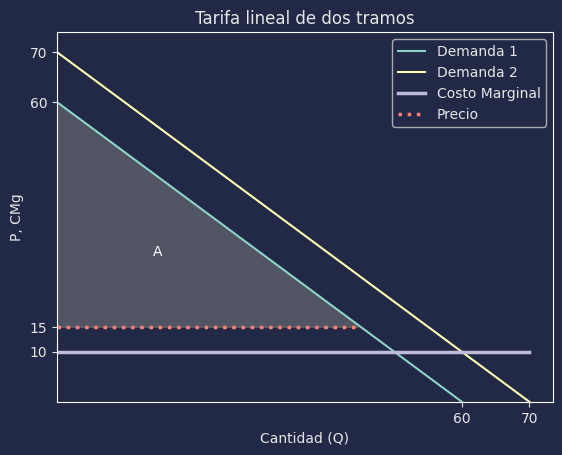

In [38]:
# 4. Evaluación de las demandas de ecuación P en función de q_x
rango_q = np.linspace(0, q_mayor_escogida_p, 100)
rango_p = np.linspace(0,solution_p_exacto_q,100)

for idx, ecuacion in enumerate(p_q[p]):
  evaluacion_p_q = [float(ecuacion[0].subs(f'q_{idx+1}', c).evalf()) for c in rango_q]
  plt.plot(rango_q, evaluacion_p_q, label=f"Demanda {idx + 1}")

# Convertir CMg_value a un numpy array y asegurarse de que sea tipo float
evaluacion_CMg_np = np.full_like(rango_q, float(CMg))
evaluacion_p_exacto_np = np.full_like(rango_p, float(precio_exacto))

# Rellenar área entre la demanda y CMg
demanda_rellenar = ecuacion_rellenar_area
evaluacion_demanda_rellenar = np.array([float(demanda_rellenar.subs(q_escogido_graficar, c).evalf()) for c in rango_q])
plt.fill_between(rango_q, evaluacion_demanda_rellenar, evaluacion_p_exacto_np, where=(evaluacion_demanda_rellenar > evaluacion_p_exacto_np), color='gray', alpha=0.5)

# Evaluo y grafico el Costo Marginal
evaluacion_CMg = np.full_like(rango_q, CMg)
plt.plot(rango_q, evaluacion_CMg, label="Costo Marginal", linewidth=2.5)

# Evaluo y grafico el Precio exacto
evaluacion_p_exacto = np.full_like(rango_q, precio_exacto)
plt.plot(rango_p, evaluacion_p_exacto, label="Precio", linestyle = 'dotted',linewidth=2.5)

# Ajustar ejes y etiquetas
plt.xlabel("Cantidad (Q)")
plt.ylabel("P, CMg")

# Definir las coordenadas del triángulo
x = [0 , solution_p_exacto_q, 0, 0]
y = [precio_exacto, precio_exacto, ecuacion_rellenar_area.subs(q_escogido_graficar, 0), precio_exacto]

# Calcular el centroide del triángulo
cx = np.mean(x[:-1])
cy = np.mean(y[:-1])

# Colocar el texto en el centroide
plt.text(cx, cy, 'A', ha='center', va='center', color='white')

q_ticks = q_constantes_p
p_ticks = p_constantes_q

'''# Obtener las marcas actuales
q_ticks = list(plt.xticks()[0])
p_ticks = list(plt.yticks()[0])

# Agregar las marcas adicionales
p_ticks.extend(p_constantes_q)
q_ticks.extend(q_constantes_p)'''

# Establecer las nuevas marcas
plt.xticks(q_ticks)
plt.yticks(p_ticks)

# Ajustar límites de los ejes
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.legend()
plt.title("Tarifa lineal de dos tramos")
plt.show()
